In [9]:
import numpy as np
import matplotlib.pyplot as plt

Install and import `causaltensor` package

In [3]:
!pip install causaltensor #install the causaltensor package
import causaltensor as ct

We solved the following convex-optimization problem:
$$
\hat{M}, \hat{\tau} = \arg\min \sum_{ij} \left(O_{ij} - \sum_{k}\tau_{k} Z^{(k)}_{ij} - M_{ij}\right)^2 + \lambda \|M\|_{*}
$$
Then, we use the following debiasing formula:
$$
\tau^{d} = \tau - D^{-1}\Delta
$$
where $D_{ij} = <P_{T^{\perp}}(Z_{i}), P_{T^{\perp}}(Z_{j})>$ and $\Delta_{i} = \lambda <Z_{i}, U V^{\top}>$.

See details in [1].

To call the function, use
```
solver = DCPanelSolver(Z=Z, O=O)
result = solver.fit(suggest_r=r)
M, tau, std = result.M, result.tau, result.std
```
where $Z$ is a list of numpy arrays. For the return parameters, `M` and `tau` are the final estimators (after debiasing) and `std` is the standard deviation estimator for `tau`.

Alternatively, we also implemented a non-convex optimization approach for the panel regression by imposing a hard constraint on the rank
$$
\hat{M}, \hat{\tau} = \arg\min_{rank(M)<=r} \sum_{ij} \left(O_{ij} - \sum_{k}\tau_{k} Z^{(k)}_{ij} - M_{ij}\right)^2
$$

To call the function, use
```
result = solver.fit(suggest_r=r. method='non-convex')
M, tau, std = result.M, result.tau, result.std
```

Finally, we provide an option to select the convex or non-convex method automatically.
```
result = solver.fit(suggest_r=r. method='auto')
M, tau, std = result.M, result.tau, result.std
```





[1] Farias, Vivek, Andrew Li, and Tianyi Peng. "Learning treatment effects in panels with general intervention patterns." Advances in Neural Information Processing Systems 34 (2021): 14001-14013.


## Data Generation

In [10]:
from causaltensor.matlib import low_rank_M0_normal
from causaltensor.matlib import iid_treatment

n1 = 100
n2 = 100
r = 2
M0 = low_rank_M0_normal(n1 = n1, n2 = n2, r = r) #low rank baseline matrix

num_treat = 5 #number of treatments
prob = 0.2
Z = []
tau = []
for k in range(num_treat):
    Z.append(iid_treatment(prob=prob, shape=M0.shape)) #treatment patterns
    tau.append(np.random.normal(loc=0, scale=1)) #treatment effects

## Empirical Experiments

In [11]:
def adding_noise(M0, Z, tau, Sigma, SigmaZ):
    num_treat = len(Z)
    O = M0 + np.random.normal(loc=0, scale=1, size=M0.shape) * Sigma #add heterogenous noise to the baseline matrix
    for k in range(num_treat):
        O += Z[k] * tau[k] + Z[k] * SigmaZ[k] * np.random.normal(loc=0, scale=1, size=M0.shape) #add heterogeneous noise to the treatment effects
    return O

In [12]:
from causaltensor.cauest.DebiasConvex import DCPanelSolver

Sigma = np.random.rand(M0.shape[0], M0.shape[1])
SigmaZ = []
for k in range(num_treat):
    SigmaZ.append(np.random.rand(M0.shape[0], M0.shape[1]))

results = []
for T in range(10000):
    O = adding_noise(M0, Z, tau, Sigma, SigmaZ)

    solver = DCPanelSolver(Z=Z, O=O)
    # result = solver.fit(suggest_r=r, method='convex')
    result = solver.fit(suggest_r=r, method='non-convex') #solving a non-convex optimization to obtain M and tau heuristically, which is often faster than the convex optimization above but the theoretical guarantee is weaker
    tau_hat, std = result.tau, result.std
    results.append(tau_hat)
results = np.array(results)

In [13]:
print('the estimated effect ', np.mean(results, axis=0)) #the mean of the estimated treatment effects
print('the true effect ', tau) #the true treatment effects

the estimated effect  [-0.75072935  0.30309977 -1.0066856   1.18465598  0.26962555]
the true effect  [-0.7453377519084576, 0.2996533275879182, -1.0017855814169108, 1.1833379615905681, 0.258677534379914]


### Empirical distribution of the estimated treatment effects (each sample has a different realization of noises)
The plot is obtained over 10000 samples (it cost ~5 minutes in a Macbook Pro)

the empirical standard deviation 0.19819497714410816


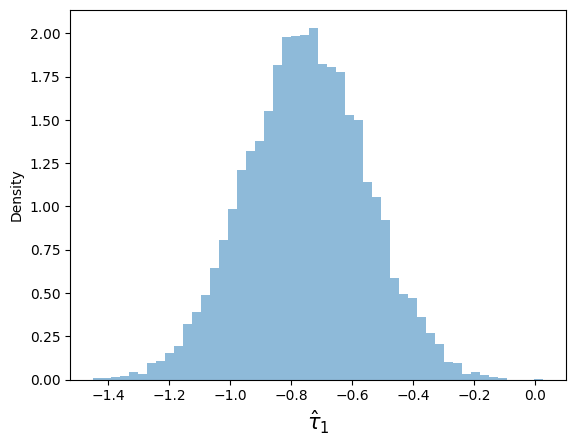

In [14]:
_ = plt.hist(results[:, 0], bins=50, density=True, alpha=0.5, label='Empirical Data')
plt.xlabel(r'$\hat{\tau}_1$', fontsize=15)
plt.ylabel('Density')
print('the empirical standard deviation', np.std(results[:, 0]))

### Compute the confidence interval given one sample

In [ ]:
O = adding_noise(M0, Z, tau, Sigma, SigmaZ)

solver = DCPanelSolver(Z=Z, O=O)
result = solver.fit(suggest_r=r, method='non-convex')
M, tau_hat, std = result.baseline, result.tau, result.std

print('the estimated standard deviation is ', std[0]) #the standard deviation of estimating tau1

the estimated standard deviation is  0.007830330672430072


### Comparing the computed confidence interval and empirical distribution

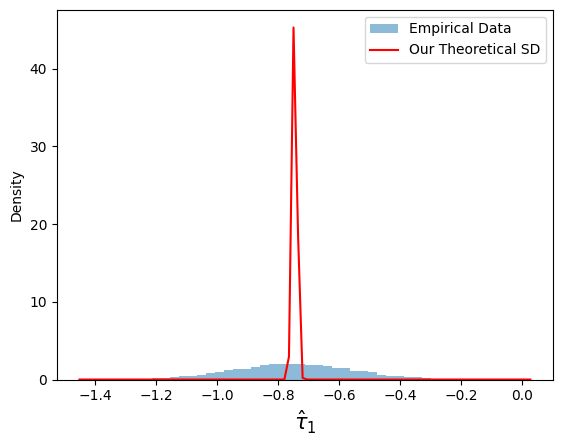

In [18]:
from scipy.stats import norm
data = results[:, 0]

# Define the Gaussian function
def gaussian(x, mean, std):
    return norm.pdf(x, loc=mean, scale=std)

# Generate x values for plotting
x = np.linspace(data.min(), data.max(), 100)

# Plot the empirical data
plt.hist(data, bins=50, density=True, alpha=0.5, label='Empirical Data')

# Plot the Gaussian fit
plt.plot(x, gaussian(x, tau[0], std[0]), 'r-', label='Our Theoretical SD')

# Add labels and a legend
plt.xlabel(r'$\hat{\tau}_1$', fontsize=15)
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()